In [1]:
!pip install kaggle

In [0]:
from getpass import getpass
import os
user = 'ahmadelsallab'
key = '6b7ffe97ff5bc0656e325b746b72fa31'

if '.kaggle' not in os.listdir('/root'):
    !mkdir ~/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 666 /root/.kaggle/kaggle.json
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"%s","key":"%s"}' % (user, key))
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c ashrae-energy-prediction

  0% 0.00/44.5k [00:00<?, ?B/s]
100% 44.5k/44.5k [00:00<00:00, 37.6MB/s]
  0% 0.00/2.53M [00:00<?, ?B/s]
100% 2.53M/2.53M [00:00<00:00, 83.4MB/s]
 95% 158M/167M [00:02<00:00, 63.7MB/s]
100% 167M/167M [00:02<00:00, 64.0MB/s]
  0% 0.00/1.27M [00:00<?, ?B/s]
100% 1.27M/1.27M [00:00<00:00, 85.4MB/s]
 93% 111M/120M [00:01<00:00, 71.2MB/s] 
100% 120M/120M [00:01<00:00, 64.9MB/s]
 93% 82.0M/88.4M [00:00<00:00, 105MB/s] 
100% 88.4M/88.4M [00:00<00:00, 121MB/s]


In [4]:
!unzip train.csv.zip
!unzip weather_train.csv.zip
!unzip building_metadata.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  weather_train.csv.zip
  inflating: weather_train.csv       
unzip:  cannot find or open building_metadata.csv.zip, building_metadata.csv.zip.zip or building_metadata.csv.zip.ZIP.


In [5]:
import pandas as pd
train = pd.read_csv('train.csv')
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [6]:
building_meta = pd.read_csv('building_metadata.csv')
building_meta.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [7]:
weather_train = pd.read_csv('weather_train.csv')
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [8]:
a = pd.DataFrame({'id':[0,1,2,3], 'key':[0,1,0,10]})
a

,id,key
0,0,0
1,1,1
2,2,0
3,3,10


In [9]:
k = pd.DataFrame({'key':[0,1], 'info':[10,20]})
k

,key,info
0,0,10
1,1,20


In [10]:
m = pd.merge(a, k)
m

,id,key,info
0,0,0,10
1,2,0,10
2,1,1,20


In [11]:
m = pd.merge(a, k, how='outer')
m

,id,key,info
0,0,0,10.0
1,2,0,10.0
2,1,1,20.0
3,3,10,NaN


In [8]:
train_df = pd.merge(train, building_meta)
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN
1,0,0,2016-01-01 01:00:00,0.0,0,Education,7432,2008.0,NaN
2,0,0,2016-01-01 02:00:00,0.0,0,Education,7432,2008.0,NaN
3,0,0,2016-01-01 03:00:00,0.0,0,Education,7432,2008.0,NaN
4,0,0,2016-01-01 04:00:00,0.0,0,Education,7432,2008.0,NaN


In [9]:
train_df = pd.merge(train_df, weather_train)
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


In [0]:
#train_df = pd.merge([train, building_meta, weather_train])
#train_df.head()

In [15]:
print(len(train))
print(len(building_meta))
print(len(weather_train))
print(len(train_df))

20216100
1449
139773
20125605


Merged df has lower len than original train data--> we have missing keys!

In [16]:
print('Num of missing vals=', len(train) - len(train_df))

Num of missing vals= 90495


Identify source of missing

In [17]:
len(train) - len(pd.merge(train, building_meta))

0

No missing vals by merging the building_metadata, so no missing building_id

So the missing vals come either from missing timestamp, or missing site_id's

We need to have all entries, although if missing some data. So we should specify the merge method. 

If we use outer, we could get extra rows, since we might have extra foreign keys not referenced.

So we use left

In [8]:
#train_df1 = pd.merge(train, building_meta, on='building_id', how='outer')# outer: You could get longer merge, due to extra building id's for example
train_df1 = pd.merge(train, building_meta, on='building_id', how='left')
print(len(train_df1) - len(train))
#train_df = pd.merge(train_df1, weather_train, on=['timestamp','site_id'], how='outer')## outer: You could get longer merge, due to extra site_id's or timestamps for example
train_df = pd.merge(train_df1, weather_train, on=['timestamp','site_id'], how='left')
print(len(train_df) - len(train_df1))


0
0


In [19]:
train_df.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed'],
      dtype='object')

In [20]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2c30d58198>,
      dtype=object)

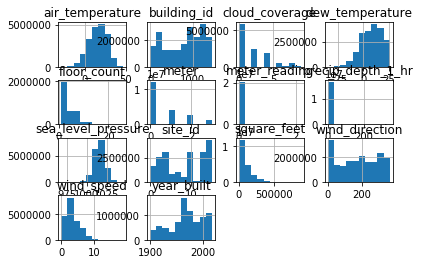

In [21]:
train_df.hist()

In [22]:
train_df.meter_reading

0             0.000
1             0.000
2             0.000
3             0.000
4             0.000
             ...   
20216095      8.750
20216096      4.825
20216097      0.000
20216098    159.575
20216099      2.850
Name: meter_reading, Length: 20216100, dtype: float64

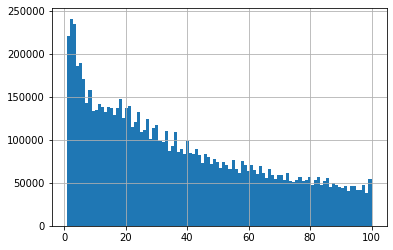

In [23]:
train_df.meter_reading.hist(bins=100, range=[1,100])
# range=[0,100] --> A lot at zero--> trim
# range=[0,10000] --> No reading > 4000
# Dist is right skewed --> log?
# 

The reason of skew is that every meter type has its own data range as we will see below.
The highest count comes from meter_id=0 (electricity), which have the lowest mean. while the highest mean of readings is for meter=2 (steam), which has low mean of readings.

It is expected that the histogram per meter type to be uniform.

However, as we see above, a lot of readings are 0's. Better to drop those.

In [27]:
print(len(train_df[train_df.meter_reading == 0]))
print(len(train_df))

1873976
20216100


In [0]:
import numpy as np
counts, divisions = np.histogram(train_df.meter_reading, bins=100, range=[1,100])

In [25]:
counts# counts on y-ax

array([221322, 241239, 235582, 186722, 189422, 170542, 142539, 158331,
       133841, 135337, 141881, 138306, 132688, 138214, 137019, 128789,
       137079, 147320, 125285, 137087, 139133, 114656, 121334, 132878,
       109672, 111127, 123873, 100719, 113845, 116842,  98280,  97160,
       110051,  87179,  93533, 108863,  85891,  89814,  83883,  99159,
        84787,  84004,  89600,  82975,  73351,  83185,  80547,  71749,
        77358,  74147,  67251,  74638,  71405,  65650,  76656,  66628,
        61967,  74976,  71187,  64404,  70992,  64579,  60288,  69741,
        61128,  55255,  66603,  59681,  54374,  59383,  58717,  53690,
        60997,  51911,  51361,  53931,  56459,  52248,  53271,  57291,
        47884,  53066,  57001,  47895,  52301,  55576,  44680,  50179,
        47873,  44961,  43824,  46303,  40139,  46145,  46478,  41968,
        41347,  46977,  38564,  53967])

In [26]:

divisions# ranges on x-ax

array([  1.  ,   1.99,   2.98,   3.97,   4.96,   5.95,   6.94,   7.93,
         8.92,   9.91,  10.9 ,  11.89,  12.88,  13.87,  14.86,  15.85,
        16.84,  17.83,  18.82,  19.81,  20.8 ,  21.79,  22.78,  23.77,
        24.76,  25.75,  26.74,  27.73,  28.72,  29.71,  30.7 ,  31.69,
        32.68,  33.67,  34.66,  35.65,  36.64,  37.63,  38.62,  39.61,
        40.6 ,  41.59,  42.58,  43.57,  44.56,  45.55,  46.54,  47.53,
        48.52,  49.51,  50.5 ,  51.49,  52.48,  53.47,  54.46,  55.45,
        56.44,  57.43,  58.42,  59.41,  60.4 ,  61.39,  62.38,  63.37,
        64.36,  65.35,  66.34,  67.33,  68.32,  69.31,  70.3 ,  71.29,
        72.28,  73.27,  74.26,  75.25,  76.24,  77.23,  78.22,  79.21,
        80.2 ,  81.19,  82.18,  83.17,  84.16,  85.15,  86.14,  87.13,
        88.12,  89.11,  90.1 ,  91.09,  92.08,  93.07,  94.06,  95.05,
        96.04,  97.03,  98.02,  99.01, 100.  ])

In [27]:
print(np.max(counts))
print(np.argmax(counts))
print('Mode = ', divisions[np.argmax(counts)])

241239
1
Mode =  1.99


In [28]:
train_df.describe()

,building_id,meter,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,8.088455e+06,3.506933e+06,2.011944e+07,1.139074e+07,2.011596e+07,1.646708e+07,1.898443e+07,1.876705e+07,2.007242e+07
mean,7.992780e+02,6.624412e-01,2.117121e+03,7.992232e+00,1.077830e+05,1.968277e+03,4.184848e+00,1.598795e+01,1.900423e+00,7.747429e+00,7.964155e-01,1.016085e+03,1.730151e+02,3.377525e+00
std,4.269133e+02,9.309921e-01,1.532356e+05,5.099060e+00,1.171424e+05,3.020815e+01,4.008277e+00,1.094729e+01,2.402909e+00,1.017867e+01,7.468997e+00,7.060539e+00,1.140574e+02,2.265694e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.830000e+02,1.900000e+03,1.000000e+00,-2.890000e+01,0.000000e+00,-3.500000e+01,-1.000000e+00,9.682000e+02,0.000000e+00,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01,3.000000e+00,3.252700e+04,1.951000e+03,1.000000e+00,8.600000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.011600e+03,7.000000e+01,2.100000e+00
50%,8.950000e+02,0.000000e+00,7.877500e+01,9.000000e+00,7.270900e+04,1.969000e+03,3.000000e+00,1.670000e+01,0.000000e+00,8.900000e+00,0.000000e+00,1.016000e+03,1.800000e+02,3.100000e+00
75%,1.179000e+03,1.000000e+00,2.679840e+02,1.300000e+01,1.391130e+05,1.993000e+03,6.000000e+00,2.410000e+01,4.000000e+00,1.610000e+01,0.000000e+00,1.020500e+03,2.800000e+02,4.600000e+00
max,1.448000e+03,3.000000e+00,2.190470e+07,1.500000e+01,8.750000e+05,2.017000e+03,2.600000e+01,4.720000e+01,9.000000e+00,2.610000e+01,3.430000e+02,1.045500e+03,3.600000e+02,1.900000e+01


In [29]:
train_df.dtypes

building_id             int64
meter                   int64
timestamp              object
meter_reading         float64
site_id                 int64
primary_use            object
square_feet             int64
year_built            float64
floor_count           float64
air_temperature       float64
cloud_coverage        float64
dew_temperature       float64
precip_depth_1_hr     float64
sea_level_pressure    float64
wind_direction        float64
wind_speed            float64
dtype: object

# Group by timestamp

In [13]:
train_df.timestamp.unique()

array(['2016-01-01 00:00:00', '2016-01-01 01:00:00',
       '2016-01-01 02:00:00', ..., '2016-12-31 21:00:00',
       '2016-12-31 22:00:00', '2016-12-31 23:00:00'], dtype=object)

In [15]:
train_df.timestamp.value_counts()

2016-12-27 22:00:00    2370
2016-12-27 21:00:00    2369
2016-12-27 20:00:00    2369
2016-12-27 17:00:00    2369
2016-12-27 19:00:00    2369
                       ... 
2016-02-26 01:00:00    1887
2016-02-23 09:00:00    1871
2016-03-23 16:00:00    1822
2016-03-13 03:00:00    1767
2016-03-13 02:00:00    1557
Name: timestamp, Length: 8784, dtype: int64

In [0]:
train_df.timestamp

# Filter by meter_id

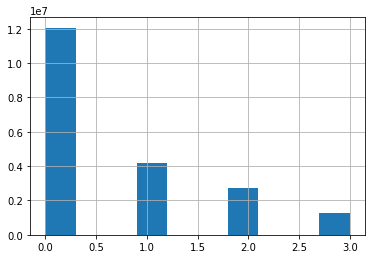

In [16]:
train_df.meter.hist()

In [31]:
train_df.meter.unique()

array([0, 3, 1, 2])

In [18]:
train_df.meter.value_counts()# same as train_df.groupby('meter').size()
# Most of data is of type 0=electricity

0    12060910
1     4182440
2     2708713
3     1264037
Name: meter, dtype: int64

In [9]:
meters_types_data = train_df.groupby('meter')
meters_types_data.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0000,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0000,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0000,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0000,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0000,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
105,106,3,2016-01-01 00:00:00,0.0000,1,Education,5374,NaN,4.0,3.8,NaN,2.4,NaN,1020.9,240.0,3.1
109,109,3,2016-01-01 00:00:00,0.0000,1,Education,56995,1953.0,6.0,3.8,NaN,2.4,NaN,1020.9,240.0,3.1
113,112,3,2016-01-01 00:00:00,96.9780,1,Education,32206,NaN,6.0,3.8,NaN,2.4,NaN,1020.9,240.0,3.1
115,113,3,2016-01-01 00:00:00,19.5970,1,Education,100481,1958.0,9.0,3.8,NaN,2.4,NaN,1020.9,240.0,3.1
117,114,3,2016-01-01 00:00:00,100.0000,1,Education,139683,1958.0,13.0,3.8,NaN,2.4,NaN,1020.9,240.0,3.1


In [38]:
meters_types_data.count()

,building_id,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
meter,,,,,,,,,,,,,,,
0,12060910,12060910,12060910,12060910,12060910,12060910,5590875,2964827,12013585,6731258,12011819,9547231,11042527,11382195,11994115
1,4182440,4182440,4182440,4182440,4182440,4182440,1362881,209891,4158938,2440144,4158099,3640875,4077393,3779896,4145110
2,2708713,2708713,2708713,2708713,2708713,2708713,567697,104597,2685881,1461042,2685226,2202497,2614929,2398650,2674539
3,1264037,1264037,1264037,1264037,1264037,1264037,567002,227618,1261038,758291,1260816,1076474,1249582,1206311,1258660


In [39]:
meters_types_data.size()

meter
0    12060910
1     4182440
2     2708713
3     1264037
dtype: int64

In [23]:
meters_types_data.mean()

,building_id,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
meter,,,,,,,,,,,,,
0,706.647989,170.825636,6.749956,92714.311950,1968.334837,3.798080,16.009653,2.284164,8.334990,0.801528,1016.407898,176.359898,3.559324
1,887.157200,633.363924,9.273534,126915.411699,1969.564241,6.342697,16.766496,1.422822,7.097000,0.760519,1015.464026,165.579998,3.078658
2,1105.916492,13882.187689,11.634820,141968.440365,1961.850078,9.030584,14.137690,1.300219,7.588065,0.967891,1016.480608,167.362113,3.143017
3,735.242757,385.866781,7.800220,115000.353802,1971.043638,5.006129,17.154435,1.187342,4.634209,0.521646,1014.437338,175.993088,3.127668


In [35]:
meters_types_data.mean().meter_reading

meter
0      170.825636
1      633.363924
2    13882.187689
3      385.866781
Name: meter_reading, dtype: float64

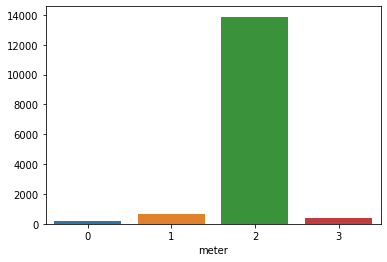

In [36]:
import seaborn as sns
sns.barplot(x=meters_types_data.mean().meter_reading.index, y=meters_types_data.mean().meter_reading.values)

We need to check if the dist of meter readings per type is skewed, or we can use the mean safely?

Hist of meter readings per metertype (expected to be uniform as described above)

In [6]:
for name, group in meters_types_data:
  print(name)
  print(group)

0
          building_id  meter  ... wind_direction  wind_speed
0                   0      0  ...            0.0         0.0
1                   1      0  ...            0.0         0.0
2                   2      0  ...            0.0         0.0
3                   3      0  ...            0.0         0.0
4                   4      0  ...            0.0         0.0
...               ...    ...  ...            ...         ...
20216095         1444      0  ...          180.0         8.8
20216096         1445      0  ...          180.0         8.8
20216097         1446      0  ...          180.0         8.8
20216098         1447      0  ...          180.0         8.8
20216099         1448      0  ...          180.0         8.8

[12060910 rows x 16 columns]
1
          building_id  meter  ... wind_direction  wind_speed
172               161      1  ...          270.0         3.6
174               162      1  ...          270.0         3.6
176               163      1  ...          270.0   

In [10]:
meters_types_data_dict = dict(list(meters_types_data))
meters_types_data_dict

{0:           building_id  meter  ... wind_direction  wind_speed
 0                   0      0  ...            0.0         0.0
 1                   1      0  ...            0.0         0.0
 2                   2      0  ...            0.0         0.0
 3                   3      0  ...            0.0         0.0
 4                   4      0  ...            0.0         0.0
 ...               ...    ...  ...            ...         ...
 20216095         1444      0  ...          180.0         8.8
 20216096         1445      0  ...          180.0         8.8
 20216097         1446      0  ...          180.0         8.8
 20216098         1447      0  ...          180.0         8.8
 20216099         1448      0  ...          180.0         8.8
 
 [12060910 rows x 16 columns],
 1:           building_id  meter  ... wind_direction  wind_speed
 172               161      1  ...          270.0         3.6
 174               162      1  ...          270.0         3.6
 176               163      1  

In [11]:
meters_types_data_dict[0]

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.000,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.000,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.000,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.000,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.000,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750,15,Entertainment/public assembly,19619,1914.0,NaN,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8
20216096,1445,0,2016-12-31 23:00:00,4.825,15,Education,4298,NaN,NaN,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8
20216097,1446,0,2016-12-31 23:00:00,0.000,15,Entertainment/public assembly,11265,1997.0,NaN,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8
20216098,1447,0,2016-12-31 23:00:00,159.575,15,Lodging/residential,29775,2001.0,NaN,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8


Now we hist the meter_reading per type
We know the means per type from above:
```
meters_types_data.mean().meter_reading

meter
0      170.825636
1      633.363924
2    13882.187689
3      385.866781
Name: meter_reading, dtype: float64
```

Remember to drop the 0 values, so the range shall start from 1 (or more)?

170.8256364480261


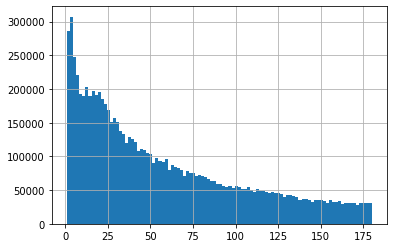

In [28]:
print(meters_types_data_dict[0].meter_reading.mean())
meters_types_data_dict[0].meter_reading.hist(bins=100, range=[1,180])

633.3639242254926


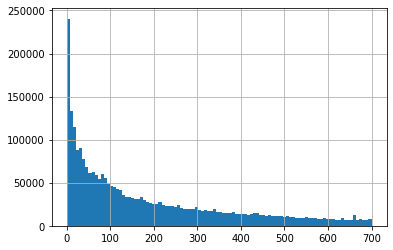

In [29]:
print(meters_types_data_dict[1].meter_reading.mean())
meters_types_data_dict[1].meter_reading.hist(bins=100, range=[1,700])

13882.18768931749


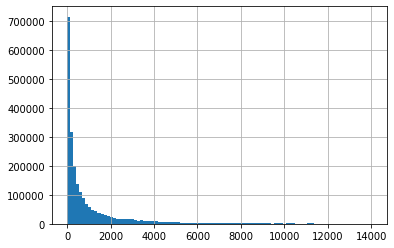

In [30]:
print(meters_types_data_dict[2].meter_reading.mean())
meters_types_data_dict[2].meter_reading.hist(bins=100, range=[1,14000])

385.86678096205117


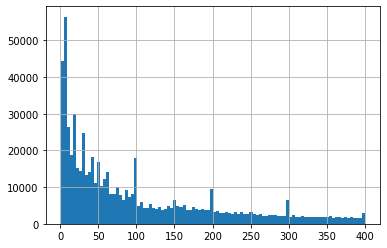

In [32]:
print(meters_types_data_dict[3].meter_reading.mean())
meters_types_data_dict[3].meter_reading.hist(bins=100, range=[1,400])

All the distributions are skewed towards the lower values. This is expected since readings are normally not high.
So the reason of skew is not only the meter type range.

Why the ranges are different per meter type?
Could the maximum is pulling the distributions of some types more.

Let's try log1p to handle this left skew.

In [0]:
import matplotlib.pyplot as plt

3.977566815545645


(array([4.28740e+04, 2.86610e+04, 1.99530e+04, 2.66820e+04, 2.63270e+04,
        2.83360e+04, 1.93590e+04, 2.77230e+04, 4.53980e+04, 4.94440e+04,
        5.19450e+04, 4.31370e+04, 4.89340e+04, 6.85460e+04, 7.54340e+04,
        8.39040e+04, 8.34700e+04, 8.42610e+04, 8.13380e+04, 9.73990e+04,
        1.03300e+05, 1.03686e+05, 1.02019e+05, 1.22399e+05, 1.16812e+05,
        1.29622e+05, 1.60330e+05, 1.69319e+05, 1.91452e+05, 2.13929e+05,
        2.25349e+05, 2.27191e+05, 2.49208e+05, 2.40231e+05, 2.69954e+05,
        2.48454e+05, 2.74923e+05, 2.80722e+05, 2.86376e+05, 2.86000e+05,
        2.96159e+05, 3.03826e+05, 3.06440e+05, 3.17860e+05, 3.17400e+05,
        2.96203e+05, 3.10398e+05, 3.16349e+05, 3.13832e+05, 2.89892e+05,
        2.92347e+05, 2.91657e+05, 2.93505e+05, 2.39320e+05, 2.04289e+05,
        1.89190e+05, 1.72415e+05, 1.58080e+05, 1.60396e+05, 1.59611e+05,
        1.62281e+05, 1.71756e+05, 1.44261e+05, 1.13158e+05, 9.63500e+04,
        7.49010e+04, 6.17140e+04, 6.32170e+04, 6.92

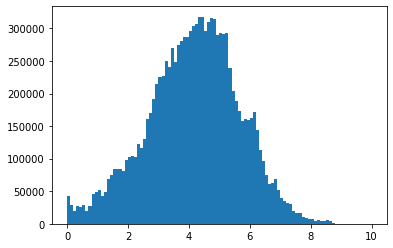

In [41]:
print(np.mean(np.log1p(meters_types_data_dict[0].meter_reading)))
plt.hist(np.log1p(meters_types_data_dict[0].meter_reading), bins=100, range=[0.00001,10])

4.246051780104299


(array([19303., 13266., 10682., 12082.,  8794.,  9418.,  9761.,  8795.,
        12960., 14516., 17024., 13969., 19002., 16419., 16413., 15600.,
        21478., 19867., 18273., 16025., 15796., 16195., 15858., 21131.,
        22420., 27165., 25766., 27144., 32254., 32464., 30948., 32416.,
        32293., 34150., 43765., 42540., 42348., 47113., 46455., 47585.,
        51980., 53550., 58498., 60911., 74888., 66319., 68360., 70872.,
        71320., 68311., 71126., 79325., 74803., 78396., 77360., 79788.,
        82090., 80093., 83845., 81336., 83827., 77918., 73581., 72959.,
        72658., 68256., 64016., 60943., 53364., 47870., 46052., 42089.,
        39386., 37282., 34431., 35132., 31504., 26520., 24806., 24043.,
        22016., 19641., 16190., 14108., 12973., 11911., 10991.,  9312.,
         7160.,  4225.,  3142.,  2342.,  2256.,  2233.,  2408.,  1296.,
          696.,   472.,   372.,   452.]),
 array([1.0000000e-05, 1.0000990e-01, 2.0000980e-01, 3.0000970e-01,
        4.0000960e-01, 5.0

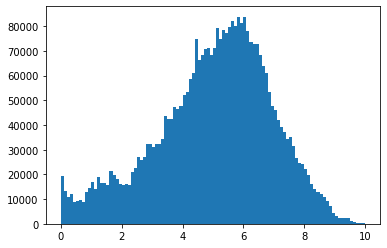

In [42]:
print(np.mean(np.log1p(meters_types_data_dict[1].meter_reading)))
plt.hist(np.log1p(meters_types_data_dict[1].meter_reading), bins=100, range=[0.00001,10])

5.123080411365783


(array([ 2226.,  2209.,  4373.,  5294.,  6489.,   327.,  1995.,  1408.,
          201.,   442.,  3195.,   214.,  1668., 12662.,  1269.,  3641.,
         1275.,   980.,   765.,  6911.,   909.,  4246.,   944.,  9829.,
         1440., 10662.,  2496.,  9617.,  6141., 14352.,  5354., 24520.,
        25808., 23294., 23201., 27694., 30403., 38290., 23482., 27782.,
        38826., 36039., 30610., 32812., 33546., 38353., 39121., 46299.,
        44826., 51026., 35632., 41086., 38993., 57343., 47795., 52717.,
        49355., 57115., 47363., 45841., 46393., 46138., 50904., 48459.,
        51084., 47840., 49404., 45833., 45957., 45666., 42248., 42184.,
        41873., 38817., 38012., 35394., 33763., 29905., 30715., 36022.,
        29181., 27000., 26158., 24583., 20972., 16224., 15113., 10536.,
         9419.,  9774.,  7839.,  7419.,  7496.,  7627.,  6678.,  5478.,
         7049.,  4221.,  3433.,  2834.]),
 array([1.0000000e-05, 1.0000990e-01, 2.0000980e-01, 3.0000970e-01,
        4.0000960e-01, 5.0

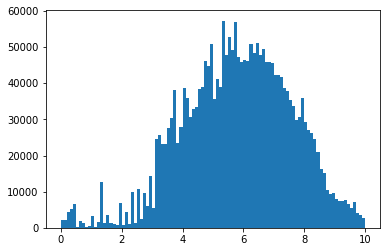

In [43]:
print(np.mean(np.log1p(meters_types_data_dict[2].meter_reading)))
plt.hist(np.log1p(meters_types_data_dict[2].meter_reading), bins=100, range=[0.00001,10])

3.324528114634765


(array([ 4154.,  5186.,  6000.,  6827.,  6170.,  5753.,  3289.,  3209.,
          926.,   678.,   853.,  1676.,  4041., 24196.,  2255.,  3110.,
         1119.,  2436.,   938., 30229.,  1505.,   823., 22817.,  7419.,
         1623., 16908.,  2124., 15297.,  2227., 14263., 15665., 12612.,
         4355., 12335., 16892., 19231., 12318., 13386., 18838., 18331.,
        18998., 17143., 15481., 17549., 16085., 16786., 27259., 13793.,
        13492., 15407., 19976., 17706., 17629., 23091., 17115., 16806.,
        15823., 20371., 16052., 17453., 15494., 17388., 17688., 15765.,
        14670., 14148., 13399., 13133., 15067., 11217., 10149., 10327.,
         7762.,  6685.,  5577.,  5270.,  4988.,  4592.,  4136.,  3324.,
         2345.,  1705.,  1545.,  1096.,  1089.,   850.,   786.,   720.,
          652.,   540.,   515.,   427.,   408.,   328.,   276.,   282.,
          251.,   231.,   211.,   169.]),
 array([1.0000000e-05, 1.0000990e-01, 2.0000980e-01, 3.0000970e-01,
        4.0000960e-01, 5.0

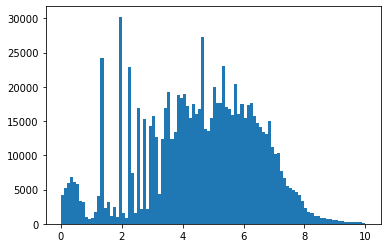

In [44]:
print(np.mean(np.log1p(meters_types_data_dict[3].meter_reading)))
plt.hist(np.log1p(meters_types_data_dict[3].meter_reading), bins=100, range=[0.00001,10])

So with log1p, we don't have skew anymore. However, we have a lot of 0 values. The means are slightly different among meter_id's 

# Distribution per meter id among time stamps

In [45]:
meters_types_data_dict[0]

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.000,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.000,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.000,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.000,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.000,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750,15,Entertainment/public assembly,19619,1914.0,NaN,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8
20216096,1445,0,2016-12-31 23:00:00,4.825,15,Education,4298,NaN,NaN,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8
20216097,1446,0,2016-12-31 23:00:00,0.000,15,Entertainment/public assembly,11265,1997.0,NaN,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8
20216098,1447,0,2016-12-31 23:00:00,159.575,15,Lodging/residential,29775,2001.0,NaN,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8


In [8]:
meters_types_data_dict[0].groupby('timestamp').mean()

,building_id,meter,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
timestamp,,,,,,,,,,,,,,
2016-01-01 00:00:00,715.118876,0.0,105.761506,6.852305,92628.129683,1967.897991,3.790560,9.931746,6.994681,1.909158,NaN,1019.902930,231.709402,3.088034
2016-01-01 01:00:00,714.659928,0.0,120.172984,6.847653,92632.789170,1967.897991,3.790560,7.617256,0.340426,1.588809,-0.288355,1021.363544,231.848375,3.526859
2016-01-01 02:00:00,714.979092,0.0,120.153222,6.850757,92647.240807,1967.897991,3.790560,7.040087,1.673882,1.389618,-0.130074,1021.542919,130.356839,2.362942
2016-01-01 03:00:00,715.200288,0.0,120.308740,6.853026,92641.260086,1967.897991,3.785294,6.524568,3.060325,0.910591,-0.129954,1021.661616,200.979021,3.367435
2016-01-01 04:00:00,715.200288,0.0,120.591857,6.853026,92641.260086,1967.897991,3.785294,6.764839,1.533333,1.033046,-0.157604,1021.769529,213.578700,3.128348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,714.695157,0.0,151.930742,6.840456,92254.787749,1968.120061,3.741379,10.329843,1.739130,0.700783,0.030493,1015.654326,188.689459,5.933689
2016-12-31 20:00:00,714.695157,0.0,150.770312,6.840456,92254.787749,1968.120061,3.741379,10.043376,2.120000,0.571011,0.030493,1014.460228,203.205928,5.403704
2016-12-31 21:00:00,714.789024,0.0,149.243467,6.842480,92173.676408,1968.147641,3.726225,10.202281,4.173050,0.691732,0.000000,1014.073440,188.759800,5.150392


In [13]:
meters_types_data_dict[0].groupby('timestamp').mean().meter_reading

timestamp
2016-01-01 00:00:00    105.761506
2016-01-01 01:00:00    120.172984
2016-01-01 02:00:00    120.153222
2016-01-01 03:00:00    120.308740
2016-01-01 04:00:00    120.591857
                          ...    
2016-12-31 19:00:00    151.930742
2016-12-31 20:00:00    150.770312
2016-12-31 21:00:00    149.243467
2016-12-31 22:00:00    147.754861
2016-12-31 23:00:00    143.522508
Name: meter_reading, Length: 8784, dtype: float64

In [14]:
meters_types_data_dict[0].groupby('timestamp').mean().meter_reading.mean()

170.67935166694534

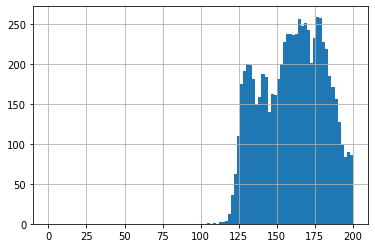

In [22]:
meters_types_data_dict[0].groupby('timestamp').mean().meter_reading.hist(bins=100, range=[0,200])

KeyboardInterrupt: ignored

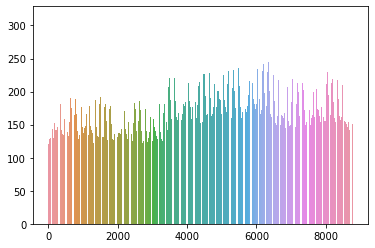

In [11]:
#sns.barplot(x=meters_types_data_dict[0].groupby('timestamp').mean().index, y=meters_types_data_dict[0].groupby('timestamp').mean().meter_reading)

In [0]:
#time_dist_0 = dict(list(meters_types_data_dict[0].groupby('timestamp')))
#time_dist_0

In [15]:
meters_types_data_dict[1].groupby('timestamp').mean().meter_reading.mean()

624.146455413373

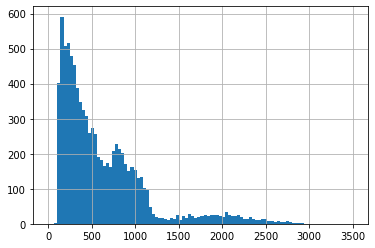

In [23]:
meters_types_data_dict[1].groupby('timestamp').mean().meter_reading.hist(bins=100, range=[0,3500])

In [16]:
meters_types_data_dict[2].groupby('timestamp').mean().meter_reading.mean()

14254.915940803245

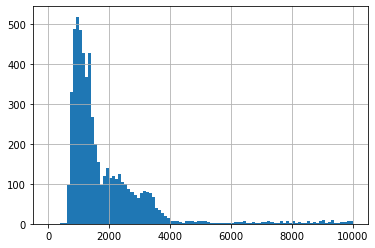

In [24]:
meters_types_data_dict[2].groupby('timestamp').mean().meter_reading.hist(bins=100, range=[0,10000])

In [17]:
meters_types_data_dict[3].groupby('timestamp').mean().meter_reading.mean()

386.05895607925174

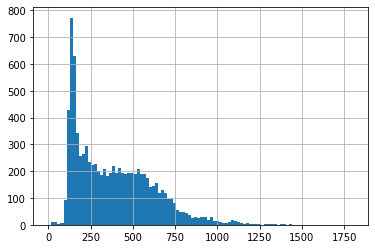

In [25]:
meters_types_data_dict[3].groupby('timestamp').mean().meter_reading.hist(bins=100, range=[0,1800])

When we get the mean per timestamp interval (1hour), we kind of remove the 0 readings. We still get skewed distributions for groups 1,2 and 3, while 0 (elec) is normal.

In [0]:
avg_reading_per_hour_0 = meters_types_data_dict[0].groupby('timestamp').mean().meter_reading

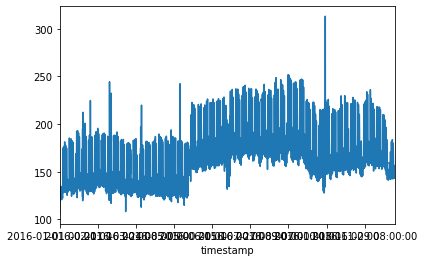

In [19]:
avg_reading_per_hour_0.plot() # Hourly

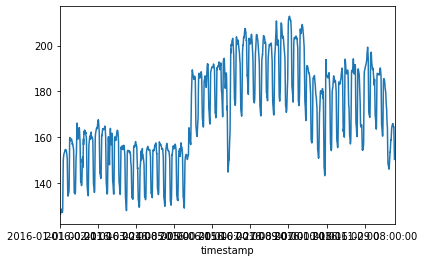

In [18]:
avg_reading_per_hour_0.rolling(24).mean().plot() # Daily

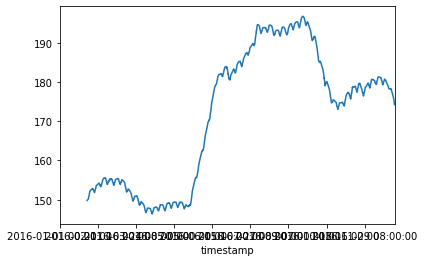

In [20]:
avg_reading_per_hour_0.rolling(24*30).mean().plot() # Monthly

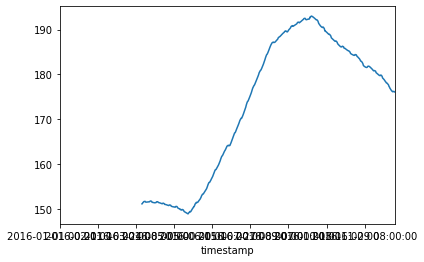

In [21]:
avg_reading_per_hour_0.rolling(24*30*3).mean().plot()

In [22]:
#avg_reading_per_hour_0.resample('Q-JAN')

TypeError: ignored

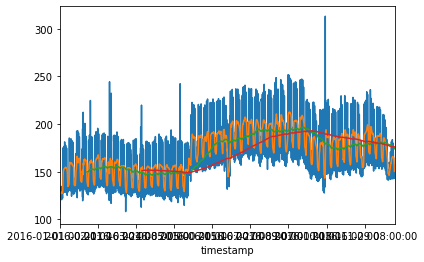

In [24]:
# Electricity pattern
avg_reading_per_hour = meters_types_data_dict[0].groupby('timestamp').mean().meter_reading
avg_reading_per_hour.plot() # Hourly
avg_reading_per_hour.rolling(24).mean().plot() # Daily
avg_reading_per_hour.rolling(24*30).mean().plot() # Monthly
avg_reading_per_hour.rolling(24*30*3).mean().plot() # Quartely

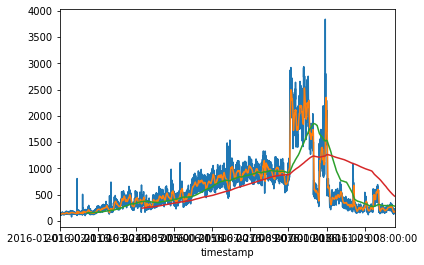

In [23]:
# chilledwater pattern
avg_reading_per_hour = meters_types_data_dict[1].groupby('timestamp').mean().meter_reading
avg_reading_per_hour.plot() # Hourly
avg_reading_per_hour.rolling(24).mean().plot() # Daily
avg_reading_per_hour.rolling(24*30).mean().plot() # Monthly
avg_reading_per_hour.rolling(24*30*3).mean().plot() # Quartely

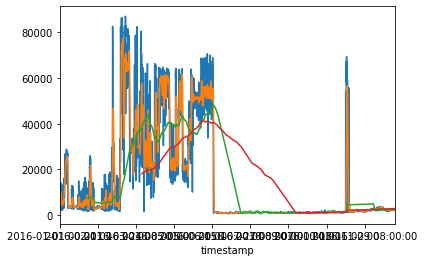

In [25]:
# steam pattern
avg_reading_per_hour = meters_types_data_dict[2].groupby('timestamp').mean().meter_reading
avg_reading_per_hour.plot() # Hourly
avg_reading_per_hour.rolling(24).mean().plot() # Daily
avg_reading_per_hour.rolling(24*30).mean().plot() # Monthly
avg_reading_per_hour.rolling(24*30*3).mean().plot() # Quartely

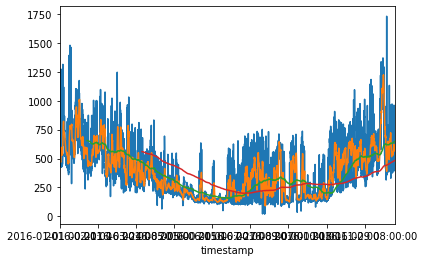

In [26]:
# hotwater pattern
avg_reading_per_hour = meters_types_data_dict[3].groupby('timestamp').mean().meter_reading
avg_reading_per_hour.plot() # Hourly
avg_reading_per_hour.rolling(24).mean().plot() # Daily
avg_reading_per_hour.rolling(24*30).mean().plot() # Monthly
avg_reading_per_hour.rolling(24*30*3).mean().plot() # Quartely

As expected, the pattern increases mostly around the end of the year (Autumn and Winter), and the start of the year. The exception is the steam pattern. The daily patterns peaks around the weakend.

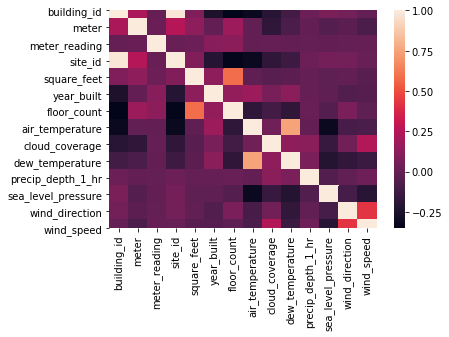

In [29]:
#plt.matshow(train_df.corr())
corr = train_df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

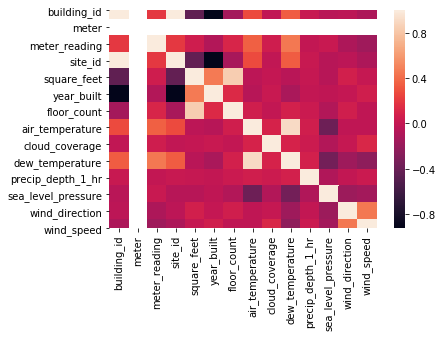

In [32]:

corr = meters_types_data_dict[0].groupby('timestamp').mean().corr() 
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

See how the meter column is insignificant now, since we already filter on it.

Now the meter reading has high correlation with dew and air temp. Which is clear also in the season dist. above.

# Filter by building_id

In [37]:
meter_types_per_building = train_df.groupby(['meter','building_id'])
meter_types_per_building.mean()

meter_reading  site_id  ...  wind_direction  wind_speed
meter building_id                          ...                            
0     0               146.454978        0  ...      156.494024    3.375114
      1                74.865393        0  ...      156.494024    3.375114
      2                14.551385        0  ...      156.494024    3.375114
      3               235.549966        0  ...      156.494024    3.375114
      4               976.556746        0  ...      156.494024    3.375114
...                          ...      ...  ...             ...         ...
3     1322           1076.998894       14  ...      187.723813    3.076776
      1323           1342.320211       14  ...      187.748026    3.076474
      1324            169.847361       14  ...      187.723813    3.076776
      1325            274.841443       15  ...      182.766049    3.507951
      1331           5520.563768       15  ...      184.415717    3.553795

[2380 rows x 12 columns]

In [33]:
train_df.building_id.unique()

array([  0,   1,   2, ..., 591, 783, 403])

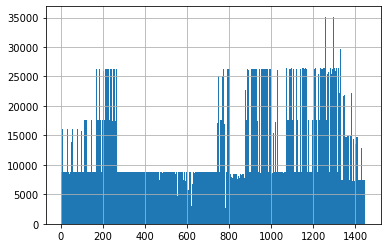

In [34]:
train_df.building_id.hist(bins=len(train_df.building_id.unique()))# Not every building has one meter

In [35]:
building_data = train_df.groupby('building_id')
building_data.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.00,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.00,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.00,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.00,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.00,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19085659,403,0,2016-12-12 01:00:00,44.35,3,Education,49500,1962.0,NaN,3.3,NaN,-2.8,0.0,1026.0,150.0,2.1
19088023,403,0,2016-12-12 02:00:00,45.45,3,Education,49500,1962.0,NaN,3.3,NaN,-2.2,0.0,1025.1,150.0,2.6
19090387,403,0,2016-12-12 03:00:00,44.82,3,Education,49500,1962.0,NaN,4.4,8.0,-1.1,0.0,1022.9,160.0,4.1
19092751,403,0,2016-12-12 04:00:00,45.11,3,Education,49500,1962.0,NaN,5.0,NaN,-1.1,0.0,1021.5,190.0,4.1


In [36]:
building_data.loc(building_id='0')

AttributeError: ignored

In [0]:
building_data.count()

# Tables joining --> train_df

## Ensure no missing keys:
- train: timestamp, building_id --> building_meta: building_id | site_id --> weather(site_id, timestamp). Checks:

1. train(timestamps) <> weather(timestamps)
2. train(building_id) <> building_meta(building_id)
3. building(train(building_id) | site_id) <> weather(site_id)

# EDA:

# Hist

# Skew?

# Target var: skew?
- Log1p + 1

# Correlation to target var



# Types: Categorical | Numerical | Ordinal | Nominal

# Missing vals
# Missing vals handling

# Outliers 

# Data prep:
## Types encoding


# Modeling
# Derived featues:
- Season: Winter|Autumn|Summer|Spring
- Weakend: Y|N
- Holiday: Y|N
- Time-of-day: day|night --> Morning|Afternoon|Evening|Night
## Featues: Xgboost:
1. Individula
2. Additive
3. Ablation

## Model:
Regression:

- xgboost
- DT
- Adaboost
- Lgbm
